In [1]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from vncorenlp import VnCoreNLP
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import joblib
import optuna
import time
import os

In [2]:
os.makedirs("./Model", exist_ok=True)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.colheader_justify', 'left')

In [6]:
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 
def preprocess(text):
    tokens = rdrsegmenter.tokenize(text)
    return " ".join(token for token in tokens[0])

data = pd.read_csv("./Dataset/vsa_food_rv_train_clean.csv", encoding="utf-8")
data['Comment'] = data['Comment'].apply(preprocess)
X = data["Comment"]
y = data["Rating"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020, test_size=0.2, stratify = y)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10326,), (10326,), (2582,), (2582,))

In [8]:
for i in range(5):
    print(i, X_train.iloc[i])

0 mình đã có một trải_nghiệm không được tốt lắm ở đây vào ngày thứ 6 ( ngày 07/06 ) mình đã cùng người_yêu và 2 người bạn khác tới đây ăn do có voucher 500 ngàn chúng_mình gọi 2 combo khoảng 350 và nước uống bạn mình có hỏi nhân_viên về voucher nhân_viên hướng_dẫn là phải check in và nhắn_tin ảnh có nội_dung check in vào page rồi dùng mã giảm_giá đó khi thanh_toán nhưng không nói về vấn_đề voucher không được sử_dụng với combo chúng_mình chọn vì_vậy sau khi ăn xong thì bạn nhân_viên đó nói rằng voucher không áp_dụng cho combo rồi bạn có xin_lỗi chúng_mình thực_sự bọn mình rất khó xử lúc đó cuối_cùng bọn mình vẫn phải trả 851 ngàn cả vat cho bữa ăn và voucher không được dùng đến trong khi ngày đó là hạn cuối voucher ( ngoài_ra thì chỗ chúng_mình ngồi rất nóng trong rau có sợi tóc như hình và món vịt xào măng tanh lắm các bạn đừng gọi nếu không quen ăn hơi tái nhé ngoài những vấn_đề đó ra thì nhân_viên rất nhiệt_tình ạ
1 mình đã mua bánh ở đây nhiều rồi chủ_yếu là su kem và choco crinkles

In [9]:
class SVM_TFIDF:
    def __init__(self):
        self.vectorizer = None
        self.classifier = None

    def hyperp_tunning(self, X, y, n_trials):
        def objective(trial):
            # Khai báo siêu tham số cần tối ưu
            ngram_start = 1
            ngram_end = trial.suggest_int("tfidf__ngram_end", 1, 2)
            ngram_range = (ngram_start, ngram_end)
            min_df = trial.suggest_categorical("tfidf__min_df", [3, 5])
            max_df = trial.suggest_categorical("tfidf__max_df", [0.9, 0.95])
            sublinear_tf = trial.suggest_categorical("tfidf__sublinear_tf", [False, True])

            kernel = trial.suggest_categorical("svc__kernel", ["linear", "rbf"])
            C = trial.suggest_float("svc__C", 0.1, 5.0, log=True)
            gamma = trial.suggest_categorical("svc__gamma", ["scale", "auto"])

            pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(
                    ngram_range=ngram_range,
                    min_df=min_df,
                    max_df=max_df,
                    sublinear_tf=sublinear_tf
                )),
                ('svc', SVC(
                    class_weight='balanced',
                    kernel=kernel,
                    C=C,
                    gamma=gamma
                ))
            ])

            scores = cross_val_score(pipeline, X, y, cv=3, scoring="f1_macro")
            return scores.mean()

        print("*** Hyper-parameters tuning with Optuna ***")
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials)

        print("Best params:", study.best_params)
        return study.best_params
        
    def fit(self, X, y, n_trials=10):
        # Huấn luyện lại với tham số tốt nhất
        best_params = self.hyperp_tunning(X, y, n_trials)
        print("*** Training with the best params ***")
        start = time.time()
        self.vectorizer = TfidfVectorizer(
            ngram_range= (1, best_params["tfidf__ngram_end"]),
            min_df=best_params["tfidf__min_df"],
            max_df=best_params["tfidf__max_df"],
            sublinear_tf=best_params["tfidf__sublinear_tf"]
        )
        X_vectorized = self.vectorizer.fit_transform(X)
        self.classifier = SVC(
            class_weight='balanced',
            kernel=best_params["svc__kernel"],
            C=best_params["svc__C"],
            gamma=best_params["svc__gamma"]
        )
        self.classifier.fit(X_vectorized, y)
        end = time.time()
        print(f"Training done after {(end - start):.2f}s")

    def predict(self, X):
        X_vectorized = self.vectorizer.transform(X)
        return self.classifier.predict(X_vectorized)

    def evaluate(self, y_true, y_pred):
        print("Evaluate for SVM classifier with TF-IDF vectorizer: ")
        print(classification_report(y_true, y_pred))


In [10]:
import warnings
warnings.filterwarnings("ignore", message=".*token_pattern.*")

In [11]:
svm = SVM_TFIDF()

print("========== RUNNING SVM - TFIDF ==========")
svm.fit(X_train, y_train)

file_path = "Model/SVM_TFIDF.pkl"
joblib.dump(svm, file_path)
size = os.path.getsize(file_path)/(1024 * 1024)
print(f"Model size : {size:.2f}MB")

[I 2025-12-29 16:26:57,651] A new study created in memory with name: no-name-bd2b57bb-45be-4fff-b9ad-713c1151e472


========== RUNNING SVM - TFIDF ==========
*** Hyper-parameters tuning with Optuna ***


[I 2025-12-29 16:29:21,480] Trial 0 finished with value: 0.42706541288455374 and parameters: {'tfidf__ngram_end': 2, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9, 'tfidf__sublinear_tf': True, 'svc__kernel': 'rbf', 'svc__C': 0.20027054786705023, 'svc__gamma': 'auto'}. Best is trial 0 with value: 0.42706541288455374.
[I 2025-12-29 16:30:01,099] Trial 1 finished with value: 0.8685463072501962 and parameters: {'tfidf__ngram_end': 1, 'tfidf__min_df': 3, 'tfidf__max_df': 0.95, 'tfidf__sublinear_tf': True, 'svc__kernel': 'linear', 'svc__C': 0.7566310497695161, 'svc__gamma': 'scale'}. Best is trial 1 with value: 0.8685463072501962.
[I 2025-12-29 16:32:23,141] Trial 2 finished with value: 0.3524168901601908 and parameters: {'tfidf__ngram_end': 2, 'tfidf__min_df': 3, 'tfidf__max_df': 0.95, 'tfidf__sublinear_tf': True, 'svc__kernel': 'rbf', 'svc__C': 3.846661331235652, 'svc__gamma': 'auto'}. Best is trial 1 with value: 0.8685463072501962.
[I 2025-12-29 16:33:31,149] Trial 3 finished with value: 0.869

Best params: {'tfidf__ngram_end': 2, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9, 'tfidf__sublinear_tf': False, 'svc__kernel': 'rbf', 'svc__C': 0.8470266467066866, 'svc__gamma': 'scale'}
*** Training with the best params ***
Training done after 53.75s
Model size : 7.84MB


In [12]:
y_pred = svm.predict(X_test)
svm.evaluate(y_test, y_pred)

Evaluate for SVM classifier with TF-IDF vectorizer: 
              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83       657
         1.0       0.93      0.96      0.94      1925

    accuracy                           0.92      2582
   macro avg       0.90      0.88      0.89      2582
weighted avg       0.91      0.92      0.91      2582



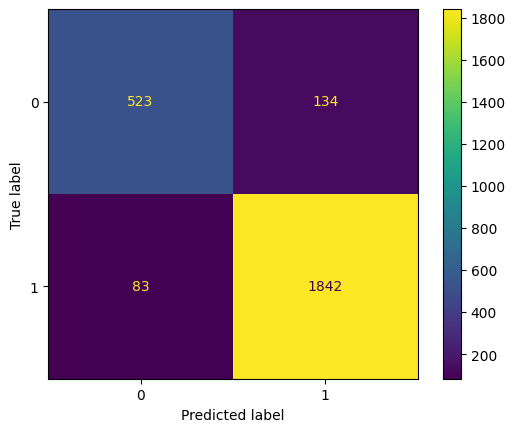

In [13]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp.plot()